<a href="https://colab.research.google.com/github/wangyouzhong/MLStudy/blob/master/Power_Prediction_MultiTask_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [48]:
import io
import pandas as pd

from google.colab import files

import numpy as np
from datetime import date, timedelta

In [49]:
TRAIN_DS_START = date(2019,2,15)
TRAIN_DS_END = date(2019,3,15)
VALIDATE_DS_START = date(2019,3,16)
VALIDATE_DS_END = date(2019,3,23)

NUM_PREVIOUS_DAYS = 1

In [50]:
# add daily sum and time bucket ratio to daily sum as features
NUM_TIME_BUCKETS = 96
START_INDEX_FEATURES = NUM_TIME_BUCKETS

def data_preprocess(df, level, train_ds_end = None):
  df.columns = ['Id', 'Date'] + [f'TB{i}' for i in range(1, NUM_TIME_BUCKETS+1)]
  df['Date'] = pd.to_datetime(df['Date']).dt.date

  # Normalize data by each node
  df = df.set_index(['Id'])
  df_max = pd.DataFrame(df.drop(columns=['Date']).groupby(['Id']).max().max(axis=1), columns=['max_value'])
  df_min = pd.DataFrame(df.drop(columns=['Date']).groupby(['Id']).min().min(axis=1), columns=['min_value'])
  df = df.join(df_max).join(df_min).reset_index()
  for i in range(1, NUM_TIME_BUCKETS+1):
    df[f'TB{i}'] = (df[f'TB{i}'] - df[f'min_value']) / (df[f'max_value'] - df[f'min_value'])

  # Add daily sum features and time bucket ratio to daily sum
  df['Day_Sum'] = df.apply(lambda row: np.sum(row[2:NUM_TIME_BUCKETS+2]) / NUM_TIME_BUCKETS, axis=1)
  for i in range(1, NUM_TIME_BUCKETS+1):
    df[f'TB{i}_Ratio'] = df.apply(lambda row: row[f'TB{i}'] / row['Day_Sum'], axis=1)

  if level == 3:
    global START_INDEX_FEATURES
    START_INDEX_FEATURES = df.shape[1] - 2

  return df

def data_shift_days(df, days_delta):
  df['Date'] = df['Date'] + pd.Timedelta(days=days_delta)
  return df

In [5]:
# uploaded1 = files.upload()

Saving 131151000000000965.csv to 131151000000000965.csv


In [51]:
df_l1 = pd.read_csv(io.BytesIO(uploaded1['131151000000000965.csv']), header=None)
df_l1 = data_preprocess(df_l1, 1).drop(columns=['Id'])
df_l1

,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,TB39,...,TB57_Ratio,TB58_Ratio,TB59_Ratio,TB60_Ratio,TB61_Ratio,TB62_Ratio,TB63_Ratio,TB64_Ratio,TB65_Ratio,TB66_Ratio,TB67_Ratio,TB68_Ratio,TB69_Ratio,TB70_Ratio,TB71_Ratio,TB72_Ratio,TB73_Ratio,TB74_Ratio,TB75_Ratio,TB76_Ratio,TB77_Ratio,TB78_Ratio,TB79_Ratio,TB80_Ratio,TB81_Ratio,TB82_Ratio,TB83_Ratio,TB84_Ratio,TB85_Ratio,TB86_Ratio,TB87_Ratio,TB88_Ratio,TB89_Ratio,TB90_Ratio,TB91_Ratio,TB92_Ratio,TB93_Ratio,TB94_Ratio,TB95_Ratio,TB96_Ratio
0,2019-01-01,0.072485,0.068886,0.059224,0.054568,0.044545,0.040000,0.033316,0.035531,0.023424,0.023212,0.022224,0.025926,0.014798,0.016488,0.010363,0.013266,0.010857,0.011507,0.016634,0.009141,0.011056,0.013511,0.010983,0.013563,0.014332,0.024428,0.029217,0.038033,0.044235,0.044906,0.059987,0.071247,0.089661,0.111188,0.125289,0.145230,0.174968,0.203223,0.233651,...,1.576228,1.577077,1.606940,1.597796,1.588869,1.606437,1.639842,1.639986,1.603359,1.622084,1.587131,1.509342,1.577066,1.580232,1.630855,1.601591,1.645309,1.673451,1.667448,1.758363,1.704935,1.646228,1.750081,1.710074,1.716819,1.738331,1.806442,1.683295,1.622658,1.657397,1.581250,1.420495,1.120077,0.969860,0.831068,0.697048,0.648068,0.602061,0.518559,0.459720
1,2019-01-02,0.071681,0.062621,0.053672,0.054030,0.043616,0.037746,0.030393,0.031674,0.022517,0.021345,0.019576,0.024428,0.013620,0.011379,0.008401,0.009904,0.007861,0.009295,0.015032,0.009170,0.007323,0.010602,0.008136,0.011211,0.012396,0.020878,0.027220,0.036121,0.040562,0.042162,0.056578,0.070240,0.088419,0.107860,0.120919,0.140241,0.169669,0.198271,0.232830,...,1.598885,1.579356,1.615887,1.634280,1.630623,1.600771,1.631815,1.645373,1.619151,1.620202,1.581086,1.520372,1.568302,1.567499,1.638584,1.625420,1.696016,1.683250,1.675380,1.716355,1.728590,1.635907,1.727624,1.729423,1.732287,1.730045,1.806895,1.708173,1.649816,1.666284,1.581322,1.449044,1.124511,0.977608,0.846783,0.691906,0.655773,0.607367,0.520036,0.464594
2,2019-01-03,0.057798,0.054576,0.045858,0.043220,0.035439,0.028421,0.020848,0.025085,0.014103,0.015140,0.011248,0.015758,0.007414,0.003705,0.002177,0.003743,0.000248,0.002856,0.006619,0.000000,0.002290,0.003760,0.000106,0.003567,0.004311,0.011602,0.018809,0.025328,0.029991,0.034815,0.048803,0.058584,0.076772,0.091369,0.105872,0.127948,0.153953,0.182271,0.207285,...,1.619173,1.591915,1.627789,1.653537,1.642437,1.650650,1.662084,1.638303,1.624279,1.663133,1.639297,1.549184,1.611918,1.594743,1.625755,1.654586,1.712044,1.709515,1.698715,1.756977,1.740580,1.685410,1.768802,1.749195,1.758798,1.792176,1.862628,1.745204,1.677032,1.650866,1.585366,1.449222,1.134689,0.975633,0.833570,0.695825,0.632650,0.588579,0.504155,0.434916
3,2019-01-04,0.068992,0.062518,0.054484,0.052397,0.042858,0.035565,0.028981,0.032689,0.021927,0.021431,0.021459,0.025552,0.011594,0.012006,0.007938,0.007827,0.007310,0.008078,0.014398,0.006294,0.007419,0.010629,0.006958,0.011019,0.012271,0.019699,0.023294,0.033367,0.039063,0.041578,0.057083,0.069509,0.086612,0.103648,0.118798,0.136061,0.167868,0.194975,0.229948,...,1.594124,1.569327,1.605799,1.633107,1.632559,1.582177,1.615528,1.614094,1.608742,1.633282,1.583888,1.547715,1.586431,1.584312,1.627412,1.611841,1.692051,1.714479,1.710211,1.751556,1.735314,1.666353,1.774865,1.734440,1.747400,1.729593,1.818192,1.680464,1.630304,1.637544,1.585262,1.435532,1.107522,0.977480,0.836175,0.709042,0.669640,0.608672,0.503639,0.468272
4,2019-01-05,0.066562,0.061918,0.054248,0.051126,0.041130,0.035466,0.027692,0.029929,0.021275,0.020982,0.017073,0.022244,0.011253,0.010265,0.006460,0.008517,0.004160,0.007459,0.014597,0.006829,0.006684,0.010149,0.007702,0.007591,0.011040,0.017526,0.023687,0.032100,0.039489,0.040679,0.053179,0.068411,0.084815,0.100746,0.114186,0.137267,0.166599,0.189824,0.221573,...,1.603115,1.568241,1.605096,1.630632,1.631188,1.603941,1.624536,1.613126,1.602954,1.6

In [52]:
df_l1['Day_Sum']

0     0.187128
1     0.183047
2     0.166545
3     0.180966
4     0.177994
        ...   
85    0.566941
86    0.535295
87    0.561684
88    0.538564
89    0.534986
Name: Day_Sum, Length: 90, dtype: float64

In [8]:
# uploaded3 = files.upload()

Saving L3.csv to L3.csv


In [53]:
df_l3 = pd.read_csv(io.BytesIO(uploaded3['L3.csv']))
df_l3 = data_preprocess(df_l3, 3, TRAIN_DS_END)
df_l3

,Id,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,TB57_Ratio,TB58_Ratio,TB59_Ratio,TB60_Ratio,TB61_Ratio,TB62_Ratio,TB63_Ratio,TB64_Ratio,TB65_Ratio,TB66_Ratio,TB67_Ratio,TB68_Ratio,TB69_Ratio,TB70_Ratio,TB71_Ratio,TB72_Ratio,TB73_Ratio,TB74_Ratio,TB75_Ratio,TB76_Ratio,TB77_Ratio,TB78_Ratio,TB79_Ratio,TB80_Ratio,TB81_Ratio,TB82_Ratio,TB83_Ratio,TB84_Ratio,TB85_Ratio,TB86_Ratio,TB87_Ratio,TB88_Ratio,TB89_Ratio,TB90_Ratio,TB91_Ratio,TB92_Ratio,TB93_Ratio,TB94_Ratio,TB95_Ratio,TB96_Ratio
0,139251010000000953,2019-01-01,0.120893,0.105923,0.096658,0.094182,0.084905,0.074636,0.069039,0.068179,0.067128,0.066309,0.062389,0.057563,0.061499,0.060135,0.058323,0.057995,0.054372,0.053679,0.055097,0.056234,0.056051,0.054188,0.050479,0.045254,0.033864,0.039849,0.031541,0.029848,0.028796,0.045990,0.062529,0.079420,0.105368,0.118045,0.137979,0.162146,0.215736,0.215935,...,1.738766,1.740273,1.746808,1.737228,1.709064,1.721022,1.728164,1.701361,1.704100,1.668395,1.678923,1.012084,1.054256,1.085870,1.076375,1.030426,0.977789,0.960879,0.970009,1.026479,0.986676,1.002360,0.958291,0.991993,1.027566,1.074665,1.140655,1.110341,1.107345,1.110904,1.138617,1.157547,1.179687,1.133700,1.127180,1.069350,1.003252,0.928550,0.863921,0.812574
1,139251010000000953,2019-01-02,0.097538,0.093647,0.085395,0.075835,0.076663,0.060679,0.059212,0.051744,0.067704,0.060542,0.062991,0.045493,0.061982,0.056432,0.050823,0.057088,0.052961,0.052081,0.055041,0.051499,0.062464,0.059757,0.053302,0.060387,0.038423,0.047168,0.034041,0.032609,0.039265,0.045724,0.060446,0.073064,0.095066,0.109328,0.127546,0.155587,0.204453,0.219170,...,1.759333,1.763780,1.765203,1.768229,1.740134,1.734980,1.750806,1.717117,1.718292,1.664021,1.632578,1.049705,1.048529,1.095232,1.111231,1.042040,1.006321,0.968628,0.942742,0.984429,0.930292,0.970467,0.872327,0.927975,0.939618,0.976370,1.056737,1.026353,1.013667,1.025012,1.019623,1.033697,0.954008,0.887413,0.834919,0.865592,0.812832,0.746236,0.714715,0.642523
2,139251010000000953,2019-01-03,0.095751,0.088853,0.083374,0.075023,0.074058,0.056372,0.054810,0.047860,0.061892,0.056350,0.058291,0.040657,0.057304,0.051535,0.046272,0.053126,0.048764,0.047525,0.050513,0.049505,0.058636,0.054031,0.045403,0.046437,0.016416,0.031668,0.027810,0.031289,0.043718,0.047106,0.056325,0.070661,0.090867,0.108792,0.128366,0.154611,0.202226,0.207121,...,1.511276,1.503694,1.498337,1.504377,1.485406,1.574986,1.675849,1.735686,1.827989,1.832479,1.855437,1.077193,1.122735,1.179239,1.183506,1.138969,1.133380,1.031574,0.953123,1.017134,0.944377,0.975224,0.878819,0.951455,0.965207,1.038481,1.156337,1.095866,1.093699,1.076343,1.082714,1.136412,1.126437,1.035362,1.032627,1.042693,0.963315,0.881722,0.829978,0.731894
3,139251010000000953,2019-01-04,0.098249,0.088747,0.088105,0.087375,0.081177,0.068782,0.065702,0.063593,0.067022,0.066659,0.064629,0.054227,0.062706,0.060582,0.057217,0.062532,0.057995,0.057941,0.057945,0.060252,0.061914,0.058464,0.054230,0.048168,0.026310,0.044459,0.052278,0.057594,0.070055,0.072461,0.078269,0.095517,0.116041,0.134155,0.148828,0.162740,0.192344,0.194396,...,1.369662,1.329332,1.302498,1.284047,1.251468,1.328547,1.416792,1.478198,1.579267,1.626159,1.717009,1.197294,1.258550,1.220882,1.155473,1.112542,1.146181,1.044485,0.956743,1.010833,0.966883,0.937638,0.939089,0.982862,1.054676,1.135231,1.253009,1.187543,1.165657,1.144282,1.153619,1.207565,1.225192,1.121678,1.193613,1.130430,1.042132,0.969101,0.900047,0.821572
4,139251010000000953,2019-01-05,0.079608,0.072377,0.062081,0.055558,0.050760,0.042620,0.038331,0.035136,0.040103,0.035314,0.034478,0.027604,0.032045,0.030378,0.027794,0.028355,0.026762,0.026388,0.029187,0.025593,0.029658,0.026846,0.020287,0.018850,0.009911,0.017164,0.018481,0.027267,0.034188,0.050323,0.064584,0.080426,0.102219,0.109142,0.124040,0.139145,0.176897,0.173171,...,1.793288,1.778081,1.774860,1.752300,

In [54]:
df_l3['Day_Sum']

0       0.155473
1       0.155065
2       0.136246
3       0.129450
4       0.118568
          ...   
8635    0.533136
8636    0.503076
8637    0.526379
8638    0.505933
8639    0.503165
Name: Day_Sum, Length: 8640, dtype: float64

In [55]:
def build_train_data(df1, df3, start_ds, end_ds, shift_days):
  train_data = pd.DataFrame.copy(df3[(df3['Date']>=start_ds) & (df3['Date']<=end_ds)]).set_index('Date')
  
  # Join L3 data with L1 previous days data
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df1[(df1['Date']>=(start_ds + timedelta(days=-i))) & (df1['Date']<=(end_ds + timedelta(days=-i)))])
    df_shift = data_shift_days(df_shift, i).set_index('Date')
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}_L1')
  
  # Join L3 data with L3 previous days data
  train_data = train_data.reset_index().set_index(['Date', 'Id'])
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df3[(df3['Date']>=(start_ds + timedelta(days=-i))) & (df3['Date']<=(end_ds + timedelta(days=-i)))])
    df_shift = data_shift_days(df_shift, i).set_index(['Date', 'Id'])
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}')
  
  # Add id and week of days as one hot features
  train_data = train_data.reset_index()
  train_data = pd.concat(
      [
       train_data, 
       pd.get_dummies(train_data['Id'], prefix='Id'),
       pd.get_dummies(train_data.apply(lambda row: row['Date'].weekday(), axis=1), prefix='Weekday')
       ],axis=1).set_index(['Date', 'Id'])

  return train_data

In [56]:
train_data = build_train_data(df_l1, df_l3, TRAIN_DS_START, TRAIN_DS_END, NUM_PREVIOUS_DAYS)
train_data

TB1       TB2  ...  Weekday_5  Weekday_6
Date       Id                                      ...                      
2019-02-15 139251010000000953  0.165962  0.153632  ...          0          0
           139251010000001761  0.158832  0.162244  ...          0          0
           139251010000002373  0.066792  0.078323  ...          0          0
           139251010000002711  0.070276  0.073480  ...          0          0
           139251010000002901  0.021960  0.027163  ...          0          0
...                                 ...       ...  ...        ...        ...
2019-03-15 139251010000063005  0.186298  0.188695  ...          0          0
           139251010000063340  0.345962  0.338919  ...          0          0
           139251010000064677  0.188826  0.162020  ...          0          0
           139251010000065186  0.189285  0.182181  ...          0          0
           139251010000073733  0.418323  0.385691  ...          0          0

[2784 rows x 688 columns]

In [57]:
NUM_TIME_BUCKETS = 96

In [60]:
train_x = train_data.values[:,START_INDEX_FEATURES:] 
train_y = pd.concat([train_data.iloc[:,:NUM_TIME_BUCKETS], train_data['Day_Sum']], axis=1).values

In [61]:
train_y

array([[0.16596242, 0.15363198, 0.13621249, ..., 0.19243379, 0.1742774 ,
        0.23205452],
       [0.1588317 , 0.16224448, 0.1594556 , ..., 0.15646251, 0.16056443,
        0.20139028],
       [0.06679168, 0.07832323, 0.05701241, ..., 0.07784591, 0.0688055 ,
        0.17624491],
       ...,
       [0.18882586, 0.16202032, 0.16500216, ..., 0.21426329, 0.20883849,
        0.36752127],
       [0.18928498, 0.18218086, 0.19061647, ..., 0.31550345, 0.23840613,
        0.40785811],
       [0.4183231 , 0.38569114, 0.34004205, ..., 0.47790481, 0.44818793,
        0.60187442]])

In [62]:
validate_data = build_train_data(df_l1, df_l3, VALIDATE_DS_START, VALIDATE_DS_END, NUM_PREVIOUS_DAYS)
validate_x = validate_data.values[:,START_INDEX_FEATURES:] 
validate_y = pd.concat([validate_data.iloc[:,:NUM_TIME_BUCKETS], validate_data['Day_Sum']], axis=1).values

In [63]:
print(train_x.shape, train_y.shape, validate_x.shape, validate_y.shape)

(2784, 493) (2784, 97) (768, 493) (768, 97)


In [64]:
train_y[0]

array([0.16596242, 0.15363198, 0.13621249, 0.12232663, 0.11716022,
       0.0978449 , 0.09174828, 0.08433908, 0.09809659, 0.08894719,
       0.08913761, 0.07402141, 0.08717461, 0.08254266, 0.07873612,
       0.08093668, 0.07786249, 0.07670844, 0.0841922 , 0.08005076,
       0.0901115 , 0.09076477, 0.08507687, 0.09380027, 0.07102498,
       0.08384674, 0.06903083, 0.07447101, 0.08424254, 0.09669813,
       0.1136157 , 0.12303857, 0.14454461, 0.15664053, 0.18941834,
       0.23581948, 0.32626452, 0.33685225, 0.31725684, 0.31763236,
       0.3091574 , 0.35149708, 0.38281374, 0.40149338, 0.40968473,
       0.40193384, 0.39464362, 0.39135704, 0.37099024, 0.37970196,
       0.38617166, 0.39200905, 0.39340784, 0.38447757, 0.38155299,
       0.37844036, 0.36752407, 0.36673379, 0.36571148, 0.36505867,
       0.3586188 , 0.37416967, 0.38580423, 0.39094822, 0.40115249,
       0.39535338, 0.39467133, 0.24653273, 0.24883205, 0.26247495,
       0.26409955, 0.24652988, 0.22336901, 0.22956749, 0.23048

# Build A DNN Model 

In [65]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense

In [66]:
NUM_FEATURES = train_x.shape[1]
NUM_OUTPUTS = train_y.shape[1]
NUM_BATCHES = 100
NUM_EPOCHS = 200

In [67]:
model = tf.keras.Sequential(
    layers = [
        tf.keras.layers.Dense(512, input_dim=NUM_FEATURES, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_OUTPUTS, activation='linear'),
    ]
)

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               252928    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1

In [69]:
model.compile(optimizer='adam',loss='mae', metrics=['mae'])

In [70]:
tf.keras.backend.clear_session()

model.fit(x=train_x, y=train_y, batch_size=NUM_BATCHES, epochs = NUM_EPOCHS, validation_data = (validate_x, validate_y), shuffle=True)

Epoch 1/200
28/28 [==============================] - 0s 7ms/step - loss: 961.8845 - mae: 961.8845 - val_loss: 0.3740 - val_mae: 0.3740
Epoch 2/200
28/28 [==============================] - 0s 3ms/step - loss: 4.6717 - mae: 4.6717 - val_loss: 0.3390 - val_mae: 0.3390
Epoch 3/200
28/28 [==============================] - 0s 4ms/step - loss: 1.4509 - mae: 1.4509 - val_loss: 0.3097 - val_mae: 0.3097
Epoch 4/200
28/28 [==============================] - 0s 4ms/step - loss: 0.8586 - mae: 0.8586 - val_loss: 0.2871 - val_mae: 0.2871
Epoch 5/200
28/28 [==============================] - 0s 3ms/step - loss: 1.1009 - mae: 1.1009 - val_loss: 0.2690 - val_mae: 0.2690
Epoch 6/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6085 - mae: 0.6085 - val_loss: 0.2535 - val_mae: 0.2535
Epoch 7/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6024 - mae: 0.6024 - val_loss: 0.2399 - val_mae: 0.2399
Epoch 8/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6645

# Evaluate the Model


In [92]:
# Model prediction
predicted_validate_y = model.predict(validate_x, batch_size = NUM_BATCHES)

df_max = np.array([validate_data['max_value'].values for i in range(NUM_TIME_BUCKETS)]).transpose()
df_min = np.array([validate_data['min_value'].values for i in range(NUM_TIME_BUCKETS)]).transpose()
denormalized_validated_y = (df_max - df_min) * validate_y[:,:-1] + df_min
denormalized_predicted_validate_y = (df_max - df_min) * predicted_validate_y[:,:-1] + df_min
nmae = np.mean([np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)) for y0, y1 in zip(denormalized_validated_y, denormalized_predicted_validate_y)])
print(nmae)

0.2298460852288852


In [93]:
denormalized_predicted_validate_y.shape

(768, 96)

In [94]:
import matplotlib.pyplot as plt

def plot_validate_data(i):
  x = list(range(1, NUM_TIME_BUCKETS+1))
  y1 = denormalized_predicted_validate_y[i]
  y0 = denormalized_validated_y[i]
  print('nmae:', np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)))
  plt.plot(x, y1, 'r', label = 'true data')
  plt.plot(x, y0, 'b', label = 'predicted data')
  plt.legend()
  plt.show()

nmae: 0.12075330407905495


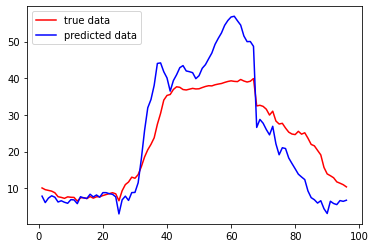

In [95]:
plot_validate_data(18)

# Save Predicted Results

In [41]:
output_file_name = 'predicted_L3_data.csv'
output_data = pd.DataFrame.copy(validate_data.iloc[:,:96])

output_data.iloc[:,:96] = denormalized_validated_y[:,:]
output_data.reset_index().set_index(['Id', 'Date']).reset_index().to_csv(output_file_name)
files.download(output_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>